## Importação das bibliotecas

In [42]:
# Bibliotecas do Sistema
import sys
import os

# Pacotes para Manipulação de Dados
import pandas as pd
import numpy as np

# Pacotes Gráficos
import matplotlib.pyplot as plt
import seaborn as sns

# Pacotes para Modelagem e Seleção de Features
from sklearn.feature_selection import f_classif

# Importação de Módulos Personalizados
sys.path.append(os.path.abspath(".."))
from src.utils import DataWrangling

### Configurações

In [43]:
# Define o número máximo de colunas exibidas pelo pandas
pd.set_option('display.max_columns', 99)

## Define o pandas para evitar a conversão silenciosa (downcasting) de tipos de dados
# pd.set_option('future.no_silent_downcasting', True)

# Define o estilo do Seaborn
sns.set_style('darkgrid')

# Definição das variáveis com as cores HEX
c_red = '#c1121f'
c_blue = '#669bbc'

## Leitura dos dados

In [44]:
# Caminho do arquivo que contém os dados brutos
raw_data_path = '../data/raw/default_of_credit_card_clients__courseware_version_1_21_19.xls'

# O pandas é usado para ler o arquivo em excel
df = pd.read_excel(raw_data_path)
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,798fc410-45c1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,8a8c8f3b-8eb4,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,85698822-43f5,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,0737c11b-be42,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,3b7f77cc-dbc0,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


## Informações iniciais

In [45]:
# Resumo do DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   ID                          30000 non-null  object
 1   LIMIT_BAL                   30000 non-null  int64 
 2   SEX                         30000 non-null  int64 
 3   EDUCATION                   30000 non-null  int64 
 4   MARRIAGE                    30000 non-null  int64 
 5   AGE                         30000 non-null  int64 
 6   PAY_1                       30000 non-null  object
 7   PAY_2                       30000 non-null  int64 
 8   PAY_3                       30000 non-null  int64 
 9   PAY_4                       30000 non-null  int64 
 10  PAY_5                       30000 non-null  int64 
 11  PAY_6                       30000 non-null  int64 
 12  BILL_AMT1                   30000 non-null  int64 
 13  BILL_AMT2                   30000 non-null  in

In [46]:
print('O dataset contém:')
print(f'{df.shape[0]} amostras')
print(f'{df.shape[1]} colunas')
print(f'{df.isna().sum().sum()} valores faltantes')
print(f'{df.duplicated().sum()} amostras duplicadas')

O dataset contém:
30000 amostras
25 colunas
0 valores faltantes
0 amostras duplicadas


### Dicionário de dados

- `ID`: Coluna de identificação exclusiva da conta

- `LIMIT_BAL`: valor do crédito fornecido inclusive o crédito do consumidor individual e familiar (complementar)

- `SEX`: Gênero (1 = masculino; 2 = feminino)

*Nota: Não usaremos os dados de gênero para tomar decisões de solvibilidade devido a considerações éticas.*

- `EDUCATION`: Instrução civil (1 = pós-graduação; 2 = universidade; 3 = ensino médio; 4 = outros).

- `MARRIAGE`: Estado civil (1 = casado; 2 = solteiro; 3 = outros).

- `AGE`: Idade (ano).

- `PAY_1`-`PAY_6`: Registro do ultimo pagamento. A escala de medida do status de reembolso é a seguinte:

    - -2 = conta começou o mês sem valor a ser pago e o crédito não foi usado;

    - -1 = pagamento pontual;

    - 0 = o pagamento mínimo foi feito, mas o saldo total devedor não foi pago

    - 1 a 8 = atraso de um a oito mêses no pagamento;

    - 9 = atraso de nove meses ou mais no pagamento.

- `BILL_AMT1`-`BILL_AMT6`: Valor da fatura

BILL_AMT1 representa o valor da fatura em setembro; BILL_AMT2 representa o valor da fatura em agosto; e assim por diante até BILL_AMT7, que representa o valor da fatura em abril.

- `PAY_AMT1`-`PAY_AMT6`: Valor de pagamentos anteriores.

PAY_AMT1 representa o valor pago em setembro; PAY_AMT2 representa o valor pago em agosto; e assim por diante até PAY_AMT6, que representa o valor pago em abril.

### Integridade dos dados

In [47]:
df['ID'].nunique()

29687

Temos IDs duplicados, vamos averiguar suas possiveis causas

In [48]:
df[df['ID'].duplicated()].describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,313.0,313.0,313.0,313.0,313.0,313.0,313.0,313.0,313.0,313.0,313.0,313.0,313.0,313.0,313.0,313.0,313.0,313.0,313.0,313.0,313.0,313.0,313.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Aparentemente houve uma condição de associação errada na consulta SQL que gerou os dados. Iremos limpar esses dados do dataset.

In [49]:
df.drop_duplicates('ID', inplace=True)
df.shape

(29687, 25)

Vamos verificar se há mais linhas com dados incorretos.

In [50]:
df.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,29687.000000,29687.000000,29687.000000,29687.000000,29687.000000,29687.000000,29687.000000,29687.000000,29687.000000,29687.000000,29687.000000,29687.000000,2.968700e+04,29687.000000,29687.000000,29687.000000,29687.000000,2.968700e+04,29687.000000,29687.000000,29687.000000,29687.000000,29687.000000
mean,167508.663051,1.603227,1.852663,1.552094,35.478964,-0.134268,-0.166066,-0.221612,-0.266682,-0.291070,51180.729848,49137.011992,4.698759e+04,43242.525853,40304.912756,38886.062182,5672.504632,5.917146e+03,5228.943275,4826.445650,4804.880116,5218.671405,0.221040
std,129719.396021,0.489374,0.789584,0.522007,9.216491,1.197400,1.197238,1.168240,1.133120,1.150617,73577.016701,71089.764364,6.929985e+04,64275.714289,60786.057141,59586.959400,16615.957728,2.310556e+04,17649.818578,15606.780656,15311.333989,17797.817169,0.414954
min,0.000000,0.000000,0.000000,0.000000,0.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.500000,2982.500000,2.661000e+03,2326.500000,1759.500000,1256.000000,1000.000000,8.320000e+02,390.000000,296.000000,249.000000,114.000000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22377.000000,21192.000000,2.010200e+04,19038.000000,18105.000000,17063.000000,2100.000000,2.008000e+03,1800.000000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67023.000000,63970.000000,6.016550e+04,54509.000000,50239.500000,49251.500000,5007.000000,5.000000e+03,4507.500000,4015.000000,4040.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.000000,621000.000000,426529.000000,528666.000000,1.000000


Como não é possivel ter clientes com idade = 0 devemos retirar esses dados.

In [51]:
unique_vals = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'default payment next month']

for col in unique_vals:
    print(col)
    print(df[col].unique())
    print('-'*30)

SEX
[2 1 0]
------------------------------
EDUCATION
[2 1 3 5 4 6 0]
------------------------------
MARRIAGE
[1 2 3 0]
------------------------------
PAY_1
[2 -1 0 -2 1 'Not available' 3 4 8 7 5 6]
------------------------------
PAY_2
[ 2  0 -1 -2  3  5  7  4  1  6  8]
------------------------------
PAY_3
[-1  0  2 -2  3  4  6  7  1  5  8]
------------------------------
PAY_4
[-1  0 -2  2  3  4  5  7  6  1  8]
------------------------------
PAY_5
[-2  0 -1  2  3  5  4  7  8  6]
------------------------------
PAY_6
[-2  2  0 -1  3  6  4  7  8  5]
------------------------------
default payment next month
[1 0]
------------------------------


As variáveis `SEX` e `MARRIAGE` possuem valores 0 que não estão no dicionário, vamos observar esses registros.

In [52]:
df[df['SEX'] == 0]

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
17317,17fb5354-37ec,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19863,5d7d605d-f03c,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Vamos realizar os seguintes ajustes:

- Remover linhas que contem somente 0 em suas features;

- Alterar o valor "Not available" da feature `PAY_1` para seu valor mais frequente;

- Alterar valores não identificados nas features `EDUCATION` e `MARRIAGE` para outros;

- Criar nova feature de categoria para `EDUCATION`.

- Converter os valores monetários de Novos Dólares Taiwaneses (NT$) para Reais (BRL)

In [53]:
# Removendo as linhas com apenas 0
df_zero = df == 0
feats_zero = df_zero.iloc[:,1:].all(axis=1)
df = df.loc[~feats_zero,:]

# Conversão monetária
taxa_cambio = 0.17636 #14/03/2025
feats_price = ['LIMIT_BAL', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 
               'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

df[feats_price] = df[feats_price] * taxa_cambio

# Alterando o 'PAY_1' para seu valor mais frequente
df = df.replace({'PAY_1': 'Not available'}, df['PAY_1'].mode().values[0])
df['PAY_1'] = df['PAY_1'].astype(int)

# Alterando valores não identificados para outros
df = df.replace({'EDUCATION': [0, 5, 6]}, 4)
df = df.replace({'MARRIAGE': 0}, 3)

# Criando nova feature
edu_cat_mapping = {
    1: 'graduate school',
    2: 'university',
    3: 'high school',
    4: 'others'
}
df['EDUCATION_CAT'] = df['EDUCATION'].map(edu_cat_mapping)

print('O dataset contém:')
print(f'{df.shape[0]} amostras')
print(f'{df.shape[1]} colunas')
print(f'{df.isna().sum().sum()} valores faltantes')
print(f'{df.duplicated().sum()} amostras duplicadas')

O dataset contém:
29685 amostras
26 colunas
0 valores faltantes
0 amostras duplicadas


/tmp/ipykernel_1953602/548941012.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({'PAY_1': 'Not available'}, df['PAY_1'].mode().values[0])


## Análise Exploratória dos Dados

Na seção de Análise Exploratória dos Dados, investigamos a fundo a estrutura e as características dos dados. Utilizamos estatísticas descritivas e visualizações para identificar padrões, tendências e outliers, além de avaliar a qualidade dos dados e as relações entre variáveis.

A primeira tarefa será criar visualizações para nossos features númericas, comparando clientes que efetivaram o pagamento versus aqueles que não o fizeram, afim de compreender melhor esses comportamentos.

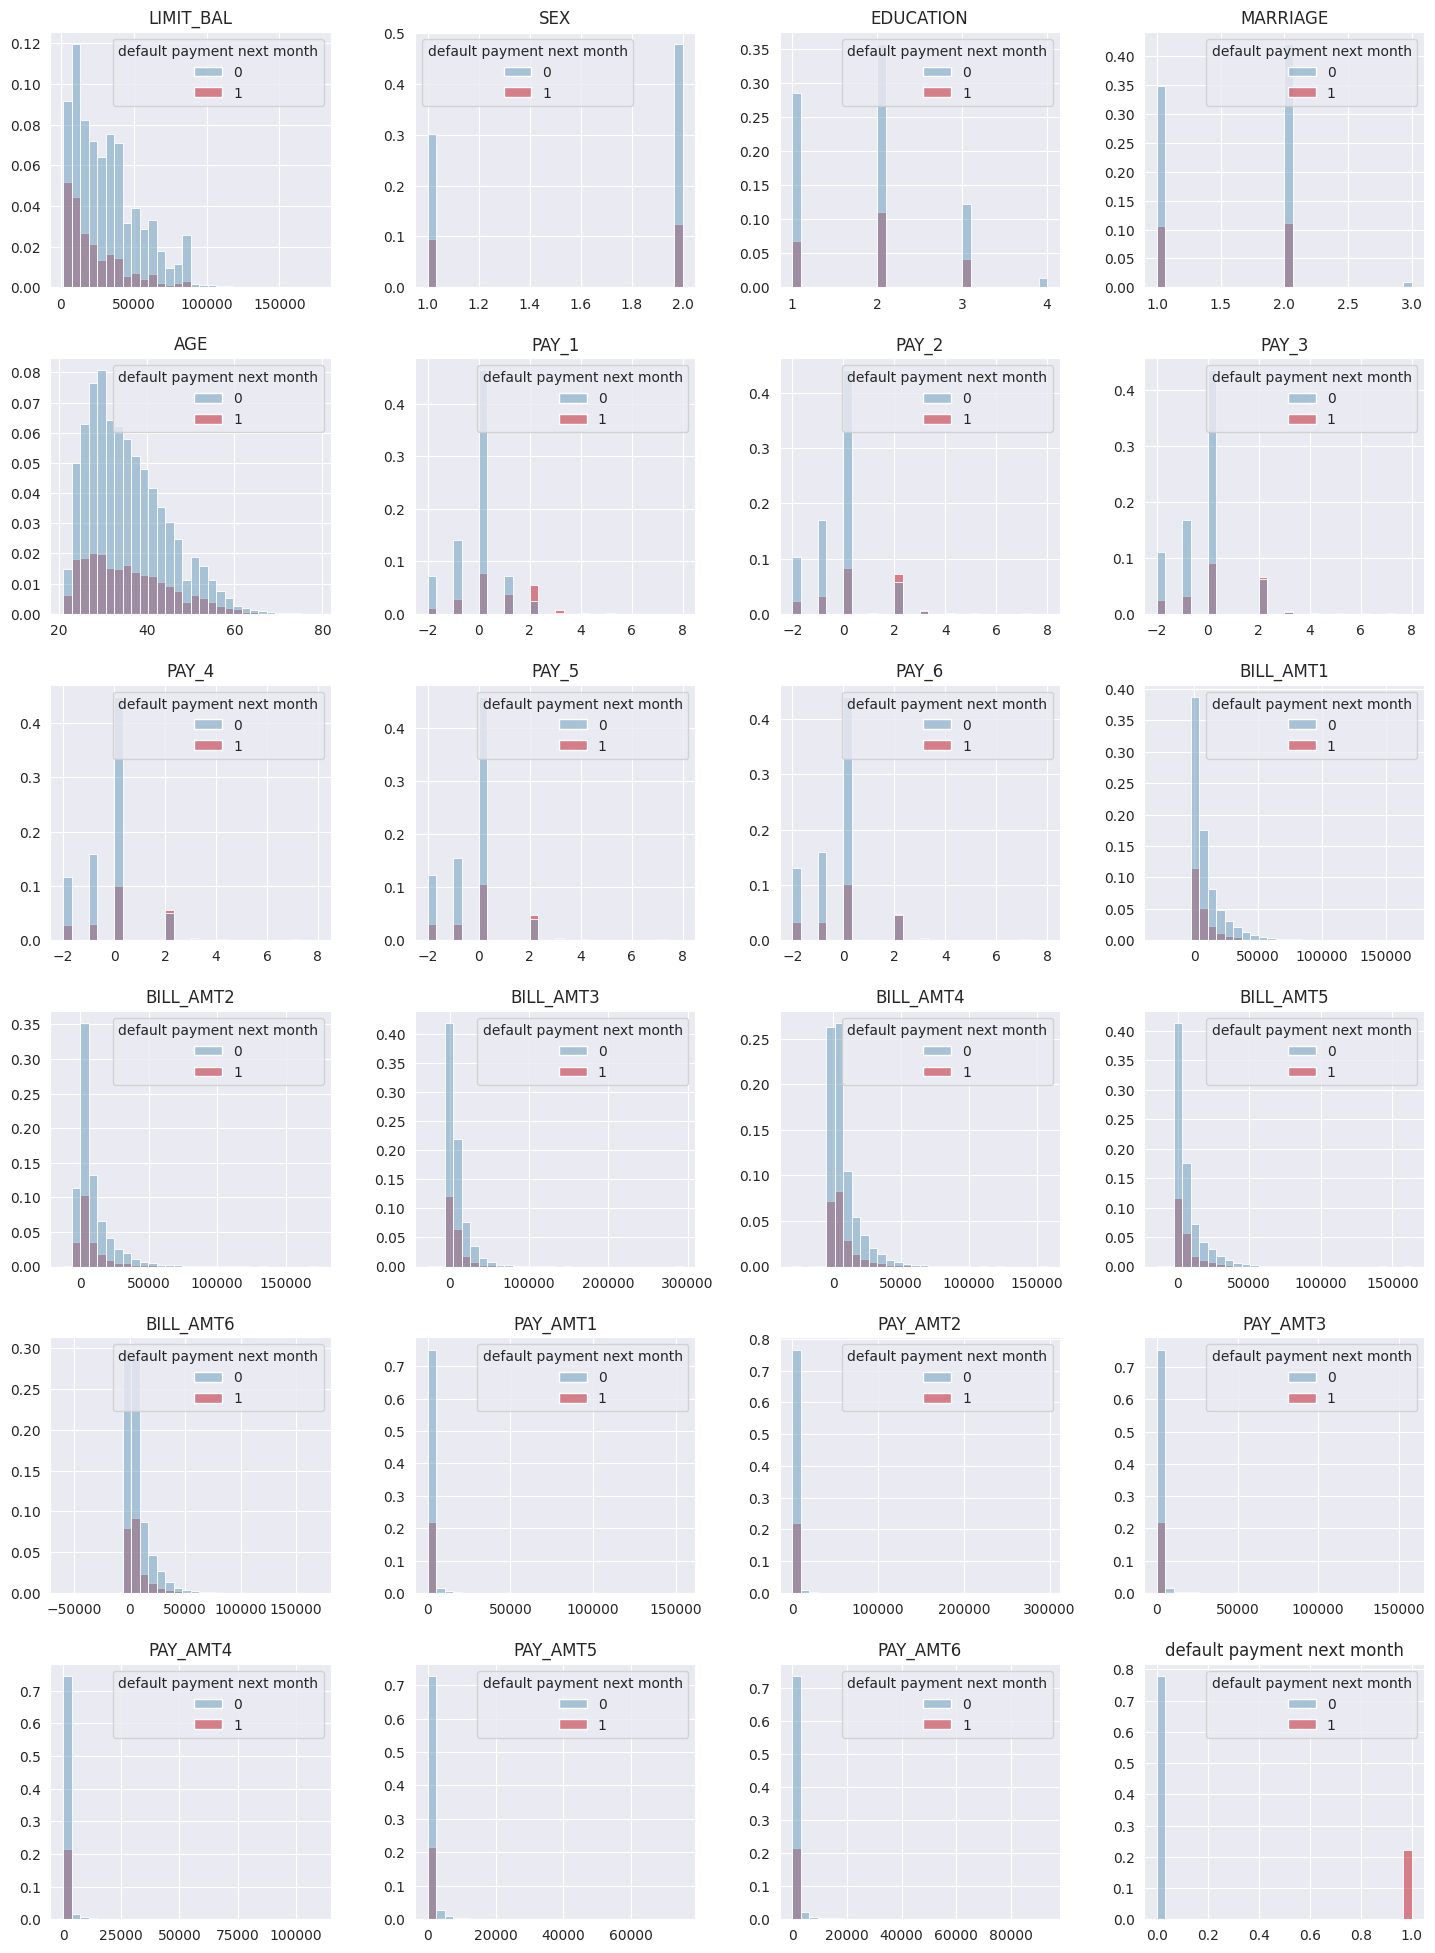

In [54]:
num_feats = df.select_dtypes([int,float])

fig, axes = plt.subplots(6, 4, figsize=(15,20))
fig.tight_layout(pad=3)

for i, col in enumerate(num_feats.columns):

    sns.histplot(num_feats, x=col, 
                 ax=axes[i//4, i%4],
                 bins=30,
                 hue='default payment next month',
                 palette=[c_blue, c_red],
                 stat='proportion')
    
    axes[i//4, i%4].set_xlabel('')
    axes[i//4, i%4].set_ylabel('')
    axes[i//4, i%4].set_title(col);

In [55]:
# Gera estatísticas descritivas para as colunas numéricas
num_feats.describe().T

,count,mean,std,min,25%,50%,75%,max
LIMIT_BAL,29685.0,29543.818170,22876.798154,1763.60000,8818.00000,24690.40000,42326.40000,176360.00000
SEX,29685.0,1.603335,0.489214,1.00000,1.00000,2.00000,2.00000,2.00000
EDUCATION,29685.0,1.842109,0.744222,1.00000,1.00000,2.00000,2.00000,4.00000
MARRIAGE,29685.0,1.557655,0.521295,1.00000,1.00000,2.00000,2.00000,3.00000
AGE,29685.0,35.481354,9.212199,21.00000,28.00000,34.00000,41.00000,79.00000
PAY_1,29685.0,-0.015968,1.067908,-2.00000,-1.00000,0.00000,0.00000,8.00000
PAY_2,29685.0,-0.134277,1.197440,-2.00000,-1.00000,0.00000,0.00000,8.00000
PAY_3,29685.0,-0.166077,1.197278,-2.00000,-1.00000,0.00000,0.00000,8.00000
PAY_4,29685.0,-0.221627,1.168278,-2.00000,-1.00000,0.00000,0.00000,8.00000
PAY_5,29685.0,-0.266700,1.133156,-2.00000,-1.00000,0.00000,0.00000,8.00000


Podemos observar que nossa feature target `default payment next month` possui uma taxa de resposta 22%, considerada baixa, mas muito comum em casos de inadimplência.

Foi identificado um problema na features `PAY_2`, `PAY_3`, `PAY_4`, `PAY_5` e `PAY_6, que exigem atenção especial no pré-processamento para evitar impactos negativos na análise e na modelagem.

In [56]:
df[df['PAY_2'] == 2][['PAY_2', 'PAY_3']].head()

,PAY_2,PAY_3
0,2,-1
1,2,0
13,2,2
15,2,0
50,2,2


Não faz sentido o ID ter um atraso de dois meses e não ter um atraso de um mês no anterior. Foi consultado com o engenheiro que relatou os datasets que houveram problemas para obter os dados e o valor 1 não foi notificado em todos os meses exceto em setembro (`PAY_1`).

Para evitar conflitos e um modelo de predição correto, iremos retirar essas features que não representam dados futuros

In [57]:
# Remoção das features PAY_
df = df.drop(['PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'], axis=1)

As variáveis PAY_AMT não fornecem muitas informações em sua forma atual de visualização. Para evidenciar melhor os padrões e reduzir a escala, aplicarei uma transformação logarítmica, tornando a análise mais clara e informativa.

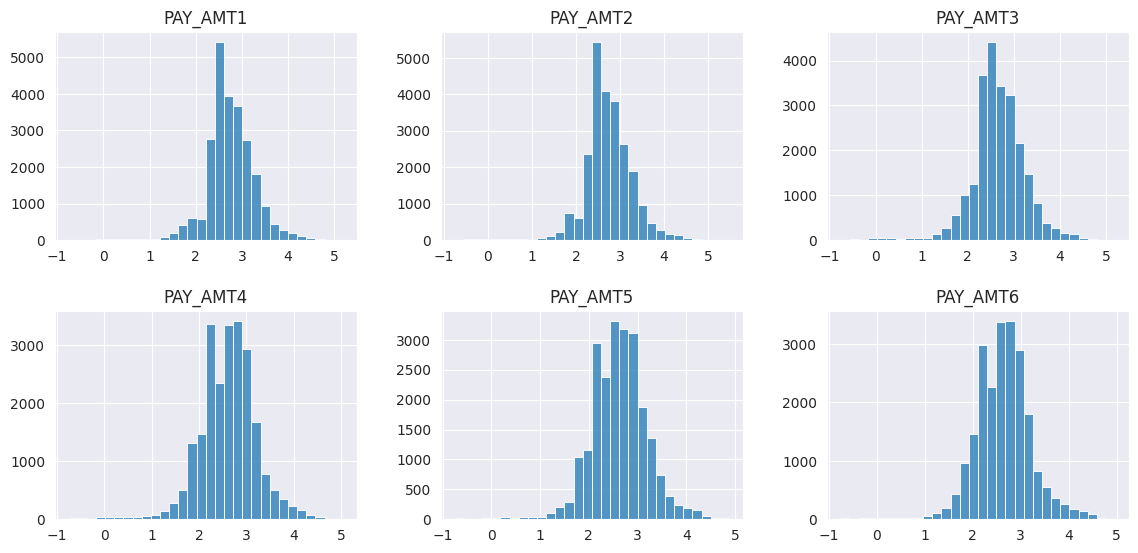

In [58]:
pay_amt_feats = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
zero_mask = df[pay_amt_feats] != 0 

pay_amt_log = df[pay_amt_feats][zero_mask].apply(np.log10)

fig, axes = plt.subplots(2, 3, figsize=(12,6))
fig.tight_layout(pad=3)

for i, col in enumerate(pay_amt_log.columns):

    sns.histplot(pay_amt_log, x=col, ax=axes[i//3, i%3], bins=30)
    axes[i//3, i%3].set_xlabel('')
    axes[i//3, i%3].set_ylabel('')
    axes[i//3, i%3].set_title(col);

Agora podemos ver que os pagamentos que mais ocorrem são na casa dos milhares.

### Matriz de Correlação

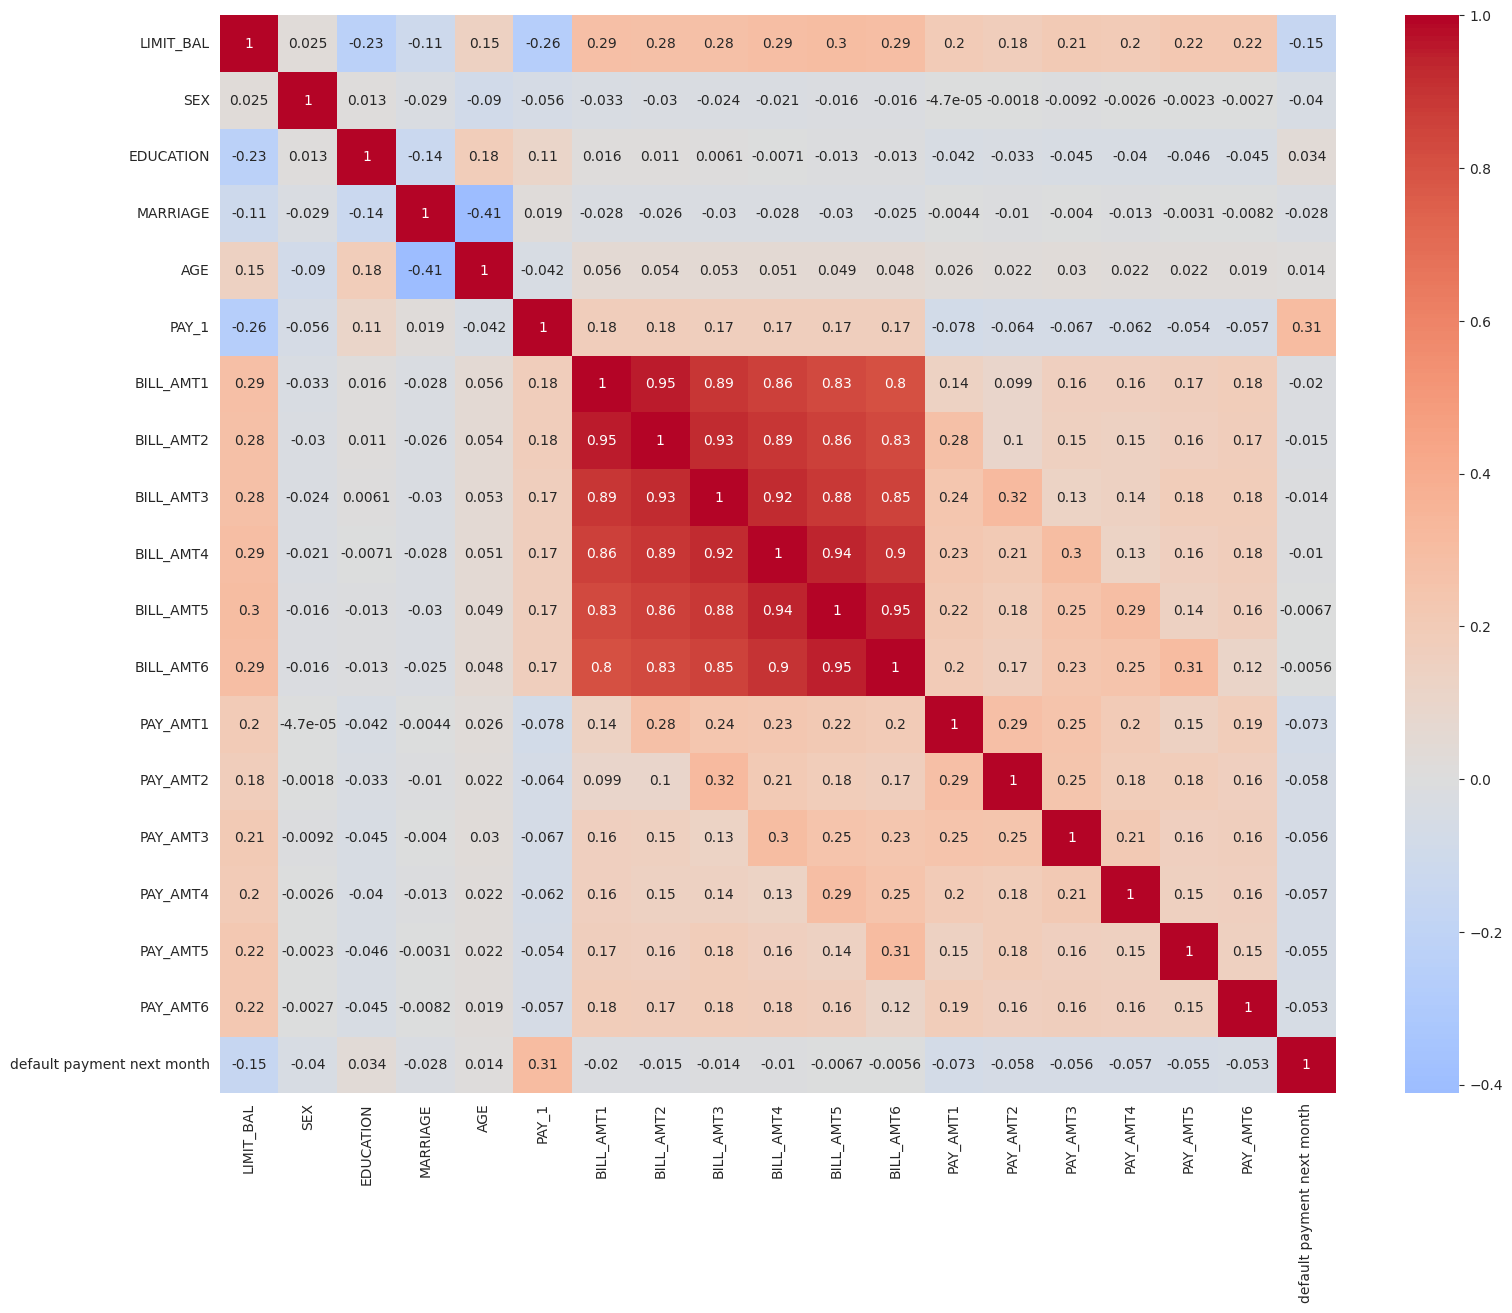

In [59]:
fig = plt.figure(figsize=(18,14))
sns.heatmap(df.corr(numeric_only=True), annot=True, center=0, cmap='coolwarm');

Podemos observar que varias características se correlacionam umas com as outras, com destaques as características de BILL_AMT. Essa interdependência sugere possíveis redundâncias e padrões relevantes.

### Teste F ANOVA

Uma maneira mais eficaz de avaliar a associação entre as variáveis e uma resposta categórica é por meio do teste F ANOVA. Esse teste estatístico mede a variabilidade entre os grupos em relação à variabilidade dentro dos próprios grupos, permitindo identificar quais características possuem maior impacto na variável alvo. Dessa forma, conseguimos selecionar as features mais relevantes para a modelagem, melhorando a performance do modelo e reduzindo a dimensionalidade dos dados.

In [70]:
# Separação das features (X) e target (y)
X = df.drop(['ID', 'default payment next month', 'EDUCATION_CAT'], axis=1)
y = df['default payment next month']

print('Shape de X:', X.shape)
print('Shape de y:', y.shape)

Shape de X: (29685, 18)
Shape de y: (29685,)


In [72]:
education_cat = pd.get_dummies(df['EDUCATION_CAT'], dtype=int, prefix='EDUCATION')

X = pd.concat([X, education_cat], axis=1)

X.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,EDUCATION_graduate school,EDUCATION_high school,EDUCATION_others,EDUCATION_university
0,3527.2,2,2,1,24,2,690.09668,547.06872,121.51204,0.00000,0.00000,0.00000,0.00000,121.51204,0.000,0.000,0.00000,0.00000,0,0,0,1
1,21163.2,2,2,2,26,-1,472.99752,304.22100,472.99752,577.04992,609.32380,575.10996,0.00000,176.36000,176.360,176.360,0.00000,352.72000,0,0,0,1
2,15872.4,2,2,2,34,0,5156.59004,2473.80172,2391.26524,2527.41516,2636.22928,2742.22164,267.71448,264.54000,176.360,176.360,176.36000,881.80000,0,0,0,1
3,8818.0,2,2,1,37,0,8287.15640,8506.37188,8692.96076,4993.45704,5107.20924,5210.90892,352.72000,356.07084,211.632,193.996,188.52884,176.36000,0,0,0,1
4,8818.0,1,2,1,57,-1,1519.69412,999.96120,6319.86060,3692.97840,3376.58856,3373.94316,352.72000,6469.06116,1763.600,1587.240,121.51204,119.74844,0,0,0,1


In [65]:

[f_stat, f_p_value] = f_classif(X,y)

f_test_df = pd.DataFrame({'Feature':X.columns,
                          'F statistic':f_stat,
                          'p value':f_p_value})

f_test_df.sort_values('p value')

,Feature,F statistic,p value
5,5,3126.713572,0.000000e+00
0,0,717.548548,3.299091e-156
12,12,158.773310,2.598410e-36
13,13,100.549372,1.259341e-23
15,15,95.463845,1.628663e-22
14,14,92.616578,6.832446e-22
16,16,89.671119,3.013470e-21
17,17,83.172561,7.980774e-20
18,18,77.473038,1.416941e-18
20,20,60.617675,7.155681e-15


Podemos chegar em conclusões semelhantes pelo DataFrame da estatística F e dos valores p e ao que observamos na plotagem de correlação de Pearson: PAY_1 e LIMIT_BAL são as características mais úteis. Elas têm p-valores menores o que indica que os valores da média dessas características entre a classe positiva e negativa são significativamente diferentes e nos ajudarão a prever a que classe uma amostra pertence.

# Insights

#### default payment next month

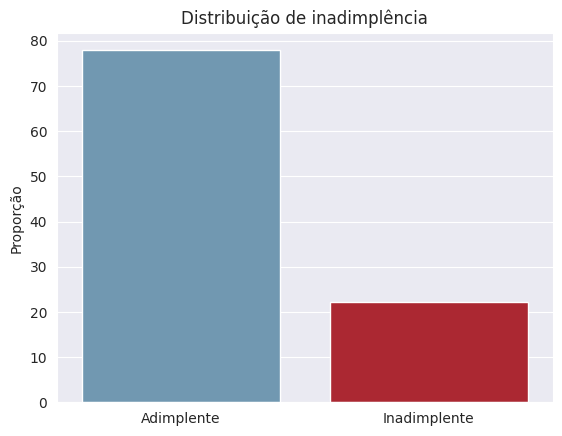

In [63]:
sns.countplot(df, x='default payment next month',
              hue='default payment next month',
              palette=[c_blue, c_red], 
              stat='percent', 
              legend=False)
              
plt.xlabel('')
plt.ylabel('Proporção')
plt.xticks(ticks=[0,1], labels=['Adimplente', 'Inadimplente'])
plt.title('Distribuição de inadimplência');

Uma característica muito comum em problemas de inadimplência é o desbalanceamento de dados. Em nosso dataset podemos observar que apenas 22% da nossa base é considerada inadimplente.

#### LIMIT_BAL

''

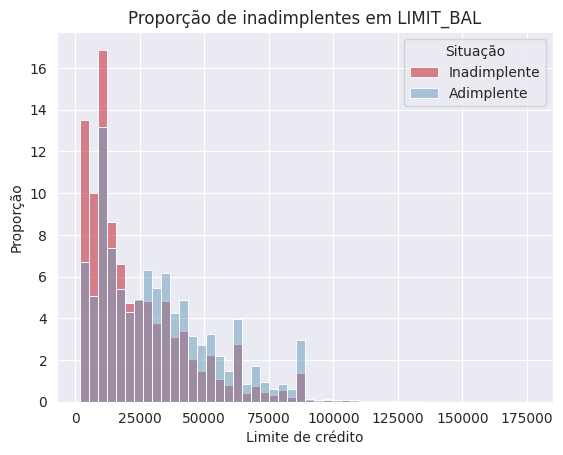

In [64]:
sns.histplot(df, x='LIMIT_BAL', 
             hue='default payment next month', 
             palette=[c_blue, c_red], 
             stat='percent',
             alpha=0.5,
             bins=50,
             kde=False,
             common_norm=False,
             legend=True)

plt.xlabel("Limite de crédito")
plt.ylabel("Proporção")
plt.title('Proporção de inadimplentes em LIMIT_BAL')
plt.legend(title="Situação", labels=['Inadimplente','Adimplente'])
;

Aparentemente, contas com limites menores de créditos, de aproximadamente NT$ 150,000 são relativamente mais propensas a inadimplir. O que faz sentido ao entender que as instituições dão limites menores a conntas que apresentam mais risco de inadimplência.